In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

import glam as gb

%load_ext autoreload
%autoreload 2

In [2]:
## Load Krajbich & Rangel (2011) dataset estimates from Thomas, Molter et al. (2019)
kr2011 = pd.read_csv('examples/KR2011_GLAM_estimates_in_sample.csv')
kr2011.head()

,subject,v,gamma,s,tau
0,39,0.000121,0.31,0.007088,0.33
1,40,0.000063,0.30,0.008777,0.55
2,41,0.000073,0.81,0.008888,0.65
3,42,0.000078,-0.17,0.008498,0.98
4,43,0.000063,0.65,0.006610,0.47


In [3]:
## Simulate a clinical dataset, with small groups and few trials
## Each individual's parameter set is sampled from the Krajbich & Rangel (2011) estimates, so that they are realistic
## Except for the gaze bias parameter gamma, which we explicitly vary between the groups.

np.random.seed(1751)

groups = ['group1', 'group2', 'group3']

# Sample sizes
N = dict(group1=5,
         group2=10,
         group3=15)

# Mean gaze bias parameters for each group
gamma_mu = dict(group1=0.7,     # weak bias
                group2=0.1,     # medium-strong bias
                group3=-0.5)    # very strong bias with leak

# Sample parameter sets from KR2011 estimates
group_idx = {group: np.random.choice(np.arange(len(kr2011)), size=N[group], replace=False)
             for group in groups}
v = {group: kr2011.loc[group_idx[group], 'v'].values
     for group in groups}
s = {group: kr2011.loc[group_idx[group], 's'].values
     for group in groups}
tau = {group: kr2011.loc[group_idx[group], 'tau'].values
       for group in groups}
# Draw normally distributed gaze bias parameters (truncated to be ≤ 1)
gamma = dict(group1=np.clip(np.random.normal(loc=gamma_mu['group1'], scale=0.3, size=N['group1']), a_min=None, a_max=1),
             group2=np.clip(np.random.normal(loc=gamma_mu['group2'], scale=0.2, size=N['group2']), a_min=None, a_max=1),
             group3=np.clip(np.random.normal(loc=gamma_mu['group3'], scale=0.3, size=N['group3']), a_min=None, a_max=1))

# Set the number of trials and items in the task
n_trials = 50
n_items  = 3

# Simulate the data using GLAM
glam = gb.GLAM()
for g, group in enumerate(groups):
    glam.simulate_group(kind='individual',
                        n_individuals=N[group],
                        n_trials=n_trials,
                        n_items=n_items,
                        parameters=dict(v=v[group],
                                        gamma=gamma[group],
                                        s=s[group],
                                        tau=tau[group],
                                        t0=np.zeros(N[group])),
                        label=group,
                        seed=g)

data = glam.data.copy()
data.rename({'condition': 'group'}, axis=1, inplace=True)
data.to_csv('examples/example_2/data/data.csv', index=False)
data.head(3)

,subject,trial,repeat,choice,rt,item_value_0,gaze_0,item_value_1,gaze_1,item_value_2,gaze_2,group
0,0.0,0.0,0.0,0.0,1316.0,5,0.459175,0,0.379466,3,0.161359,group1
1,0.0,1.0,0.0,2.0,1235.0,3,0.389115,7,0.189588,9,0.421297,group1
2,0.0,2.0,0.0,1.0,1771.0,3,0.269665,5,0.409055,2,0.321280,group1


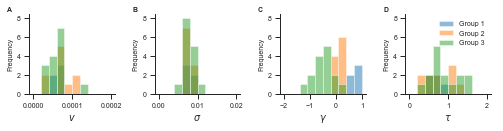

In [ ]:
## Plot data generating parameters
from string import ascii_uppercase

fontsize = 7
n_bins = 10

group_names = ['Group 1', 'Group 2', 'Group 3']

fig, axs = plt.subplots(1, 4, figsize=gb.plots.cm2inch(18, 5), sharey=True)
for p, (parameter, parameter_name, bins) in enumerate(
    zip([v, s, gamma, tau],
        [r'$v$', r'$\sigma$', r'$\gamma$', r'$\tau$'],
        [np.linspace(0, 0.0002, n_bins + 1),
         np.linspace(0, 0.02, n_bins + 1),
         np.linspace(-2, 1, n_bins + 1),
         np.linspace(0, 2, n_bins + 1)])):
    for g, (group, name) in enumerate(zip(groups, group_names)):
        axs[p].hist(parameter[group],
                    bins=bins,
                    color='C{}'.format(g),
                    label=name,
                    alpha=0.5)
        axs[p].set_xlabel(parameter_name)
        axs[p].set_ylabel('Frequency', fontsize=fontsize)
        axs[p].spines['top'].set_visible(False)
        axs[p].spines['right'].set_visible(False)

for ax, letter in zip(axs, ascii_uppercase):
    # Show ticklabels, despite sharey=True
    ax.yaxis.set_tick_params(labelbottom=True)
    ax.text(-0.2, 1.1,
            letter,
            transform=ax.transAxes,
            fontweight='bold',
            va='top',
            ha='right',
            fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

axs[-1].legend(frameon=False, fontsize=fontsize)
fig.tight_layout()
plt.savefig('examples/example_2/figures/generating_parameters.png', dpi=330)

In [ ]:
## Check if the generating parameters, due to sampling, differ between groups, other than the gaze bias
from scipy.stats import ttest_ind

parameters = ['v', 'gamma', 's', 'tau']
comparisons=[('group1', 'group2'),
             ('group1', 'group3'),
             ('group2', 'group3')]

for p, parameter in zip([v, gamma, s, tau], ['v', 'gamma', 's', 'tau']):
    print(parameter)
    for comparison in comparisons:
        g1, g2 = comparison
        print('{} vs {}\t'.format(g1, g2), ttest_ind(p[g1], p[g2]))

v
group1 vs group2	 Ttest_indResult(statistic=-0.35037217001564336, pvalue=0.7316713185392455)
group1 vs group3	 Ttest_indResult(statistic=0.5249311631156552, pvalue=0.6060368335354323)
group2 vs group3	 Ttest_indResult(statistic=0.9907257643729441, pvalue=0.33212854186194674)
gamma
group1 vs group2	 Ttest_indResult(statistic=6.4021176850791575, pvalue=2.3355862858023058e-05)
group1 vs group3	 Ttest_indResult(statistic=6.8208382105890335, pvalue=2.193832426730825e-06)
group2 vs group3	 Ttest_indResult(statistic=4.837346716941595, pvalue=6.985175866537608e-05)
s
group1 vs group2	 Ttest_indResult(statistic=0.755249267056832, pvalue=0.4635639436073751)
group1 vs group3	 Ttest_indResult(statistic=0.0912626451561753, pvalue=0.9282918625643286)
group2 vs group3	 Ttest_indResult(statistic=-0.7074562833962458, pvalue=0.486390266204882)
tau
group1 vs group2	 Ttest_indResult(statistic=-0.9174839311576268, pvalue=0.3755970768329623)
group1 vs group3	 Ttest_indResult(statistic=-1.6117169976963737,

/Users/felixmolter/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
/Users/felixmolter/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


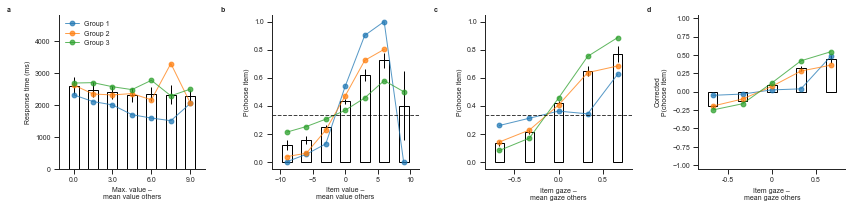

In [ ]:
## Plot aggregate data across groups and for each group separately, to visualize behavioural differences between groups
gb.plots.plot_aggregate(bar_data=data,
                        line_data=[data.loc[data['group'] == group] for group in groups],
                        line_labels=group_names,
                        value_bins=7, gaze_bins=7);
sns.despine()
plt.savefig('examples/example_2/figures/aggregate_data.png', dp=330)

In [ ]:
hglam = gb.GLAM(data=data)
hglam.make_model(kind='hierarchical',
                 depends_on=dict(v='group',
                                 gamma='group',
                                 s='group',
                                 tau='group'))

Generating hierarchical model for 30 subjects...


/Users/felixmolter/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [ ]:
np.random.seed(1802)
hglam.fit(method='MCMC',
          draws=10000, tune=90000,
          random_seed=1802)

In [ ]:
hglam.estimates.to_csv('examples/example_2/results/estimates.csv', index=False)

In [ ]:
from traceplot import traceplot
traceplot(hglam.trace[0],
          varnames=['v_group1_mu', 'v_group2_mu', 'v_group3_mu',
                    'gamma_group1_mu', 'gamma_group2_mu', 'gamma_group3_mu',
                    's_group1_mu', 's_group2_mu', 's_group3_mu',
                    'tau_group1_mu', 'tau_group2_mu', 'tau_group3_mu'],
          ref_val=dict(v_group1_mu=v['group1'].mean(),
                       v_group2_mu=v['group2'].mean(),
                       v_group3_mu=v['group3'].mean(),
                       gamma_group3_mu=gamma['group3'].mean(),
                       gamma_group1_mu=gamma['group1'].mean(),
                       gamma_group2_mu=gamma['group2'].mean(),
                       s_group3_mu=s['group3'].mean(),
                       s_group1_mu=s['group1'].mean(),
                       s_group2_mu=s['group2'].mean(),
                       tau_group3_mu=tau['group3'].mean(),
                       tau_group1_mu=tau['group1'].mean(),
                       tau_group2_mu=tau['group2'].mean()))
plt.savefig('examples/example_2/figures/traceplot.png', dpi=330)

In [ ]:
sns.set_style('ticks')
sns.set_context('paper')
parameters = ['v', 'gamma', 's', 'tau']
comparisons=[('group1', 'group2'),
             ('group1', 'group3'),
             ('group2', 'group3')]

gb.plots.plot_node_hierarchical(hglam,
                                parameters=parameters,
                                comparisons=comparisons);
plt.savefig('examples/example_2/figures/node_comparison.png', dpi=330)